<a href="https://colab.research.google.com/github/WajeehAlamoudi/skinlite/blob/master/skinliteCOLABmobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os

DATASET_PATH = "/content/drive/MyDrive/dataset"

TRAIN_IMG_DIR = os.path.join(DATASET_PATH, "images/train")
TEST_IMG_DIR = os.path.join(DATASET_PATH, "images/test")
VAL_IMG_DIR = os.path.join(DATASET_PATH, "images/val")

TRAIN_LABELS_DIR = os.path.join(DATASET_PATH, "labels/ISIC2018_Task3_Training_GroundTruth.csv")
TEST_LABELS_DIR = os.path.join(DATASET_PATH, "labels/ISIC2018_Task3_Test_GroundTruth.csv")
VAL_LABELS_DIR = os.path.join(DATASET_PATH, "labels/ISIC2018_Task3_Validation_GroundTruth.csv")


In [4]:
for path in [TRAIN_IMG_DIR, VAL_IMG_DIR, TEST_IMG_DIR, TRAIN_LABELS_DIR]:
    print(f"{path}: {'✅ Found' if os.path.exists(path) else '❌ Missing'}")


/content/drive/MyDrive/dataset/images/train: ✅ Found
/content/drive/MyDrive/dataset/images/val: ✅ Found
/content/drive/MyDrive/dataset/images/test: ✅ Found
/content/drive/MyDrive/dataset/labels/ISIC2018_Task3_Training_GroundTruth.csv: ✅ Found


In [54]:
from torch.utils.data import Dataset
import os
import pandas as pd
from PIL import Image

CLASS_NAMES = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
LABEL_MAP = {name: idx for idx, name in enumerate(CLASS_NAMES)}

CLASS_MULTIPLIER = {
    6: 5,   # VASC
    5: 5,   # DF
    4: 0,   # BKL
    3: 3,   # AKIEC
    2: 2,   # BCC
    1: -2,  # NV (downsample)
    0: 3    # MEL
}

class ISICDataset(Dataset):
    def __init__(self, csv_path, img_dir, set_state, transform=None):
        self.transform = transform
        self.set_state = set_state.lower()
        self.img_dir = img_dir

        df = pd.read_csv(csv_path)
        base_samples = []
        for _, row in df.iterrows():
            image_id = row['image']
            label_name = row[CLASS_NAMES].astype(int).idxmax()
            label = LABEL_MAP[label_name]
            base_samples.append((f"{image_id}.jpg", label))

        # === Expand or reduce samples for training
        if self.set_state == 'train':
            class_img_dict = {}
            for path, label in base_samples:
                class_img_dict.setdefault(label, []).append(path)

            expanded = []
            for label, paths in class_img_dict.items():
                multiplier = CLASS_MULTIPLIER.get(label, 1)

                if multiplier > 0:
                    expanded.extend([(path, label) for path in paths for _ in range(multiplier)])
                elif multiplier < 0:
                    keep_every = abs(multiplier)
                    reduced = paths[::keep_every]
                    expanded.extend([(path, label) for path in reduced])
                else:
                    expanded.extend([(path, label) for path in paths])

            self.samples = expanded

        elif self.set_state in ['val', 'test']:
            self.samples = base_samples
        else:
            raise ValueError("Invalid set_state. Choose from ['train', 'val', 'test']")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name, label = self.samples[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [55]:
import torch
import torchvision.transforms as transforms
import numpy as np
import random
from PIL import ImageEnhance

class AddGaussianNoiseToRandomPixels:
    def __init__(self, noise_level=0.2, p=0.5):
        self.noise_level = noise_level
        self.p = p

    def __call__(self, tensor):
        if random.random() < self.p:
            c, h, w = tensor.shape
            num_noisy_pixels = int(h * w * 0.1)
            for _ in range(num_noisy_pixels):
                i = random.randint(0, h - 1)
                j = random.randint(0, w - 1)
                tensor[:, i, j] += torch.randn(c) * self.noise_level
            tensor = torch.clamp(tensor, 0.0, 1.0)
        return tensor


class RandomFIXEDRotation:
    def __init__(self, angles=(0, 90, 180, 270), p=0.5):
        self.angles = angles
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            return transforms.functional.rotate(img, random.choice(self.angles))
        return img


class ColorConstancyTransform:
    def __init__(self, power=6, gamma=1.0):
        self.power = power
        self.gamma = gamma

    def __call__(self, tensor):
        img = tensor.numpy()
        img = img ** (1 / self.gamma)
        norm = np.power(np.sum(np.power(img, self.power), axis=(1, 2), keepdims=True), 1 / self.power)
        img = img / norm
        img = np.clip(img, 0, 1)
        return torch.tensor(img, dtype=torch.float32)


In [56]:
output_size = 224
long_side = 280

train_transform = transforms.Compose([
    transforms.Resize((output_size, long_side)),
    transforms.CenterCrop((output_size, output_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    RandomFIXEDRotation(),
    transforms.ColorJitter(brightness=(0.8, 1.1)),
    transforms.ColorJitter(contrast=(0.8, 1.1)),
    transforms.ColorJitter(saturation=(0.8, 1.1)),
    transforms.ToTensor(),

])

val_transform = transforms.Compose([
    transforms.Resize((output_size, long_side)),
    transforms.CenterCrop((output_size, output_size)),
    transforms.ToTensor()
])


In [57]:
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torch


train_set = ISICDataset(
    csv_path=TRAIN_LABELS_DIR,
    img_dir=TRAIN_IMG_DIR,
    set_state='train',
    transform=train_transform
)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)


# Test one batch
images, labels = next(iter(train_loader))
print("Image batch shape:", images.shape)
print("Label batch:", labels.tolist())


Image batch shape: torch.Size([32, 3, 224, 224])
Label batch: [5, 0, 1, 0, 1, 4, 3, 1, 1, 3, 1, 1, 3, 1, 1, 0, 5, 3, 0, 2, 4, 0, 0, 3, 1, 0, 4, 4, 0, 1, 0, 0]


In [58]:
from collections import Counter
import torch

def compute_loader_class_weights(dataset, num_classes=7):
    label_counts = Counter(label for _, label in dataset.samples)
    total = sum(label_counts.values())
    weights = [total / (num_classes * label_counts.get(i, 1)) for i in range(num_classes)]
    print(weights)
    normed = torch.tensor(weights, dtype=torch.float32)
    print(normed)
    return normed / normed.sum()



In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch import nn

class_weights = compute_loader_class_weights(train_set).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)



[0.4742651777692209, 0.4722849473818755, 1.5404391328515843, 1.6142420270860638, 1.4409203171714546, 2.7540372670807454, 2.2303822937625752]
tensor([0.4743, 0.4723, 1.5404, 1.6142, 1.4409, 2.7540, 2.2304])


In [60]:
import torch.nn as nn
from torchvision import models

class MobileNetClassifier(nn.Module):
    def __init__(self, num_classes=7):
        super(MobileNetClassifier, self).__init__()
        base = models.mobilenet_v2(pretrained=True)
        self.features = base.features
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(1280, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x


In [61]:

model = MobileNetClassifier(num_classes=7).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [62]:
EPOCHS = 10
train_losses = []

model.train()
for epoch in range(1, EPOCHS + 1):
    running_loss = 0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        #print("Capsule norm mean:", outputs.norm(dim=1).mean().item())
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    acc = correct / total
    train_losses.append(avg_loss)

    print(f"Epoch {epoch} | Train Loss: {avg_loss:.4f} | Accuracy: {acc:.4f}")


Epoch 1 | Train Loss: 1.0384 | Accuracy: 0.5862
Epoch 2 | Train Loss: 0.7973 | Accuracy: 0.6636
Epoch 3 | Train Loss: 0.6789 | Accuracy: 0.6978
Epoch 4 | Train Loss: 0.6458 | Accuracy: 0.7092
Epoch 5 | Train Loss: 0.5870 | Accuracy: 0.7343
Epoch 6 | Train Loss: 0.5683 | Accuracy: 0.7374
Epoch 7 | Train Loss: 0.5079 | Accuracy: 0.7587
Epoch 8 | Train Loss: 0.4975 | Accuracy: 0.7581
Epoch 9 | Train Loss: 0.4471 | Accuracy: 0.7825
Epoch 10 | Train Loss: 0.4569 | Accuracy: 0.7801


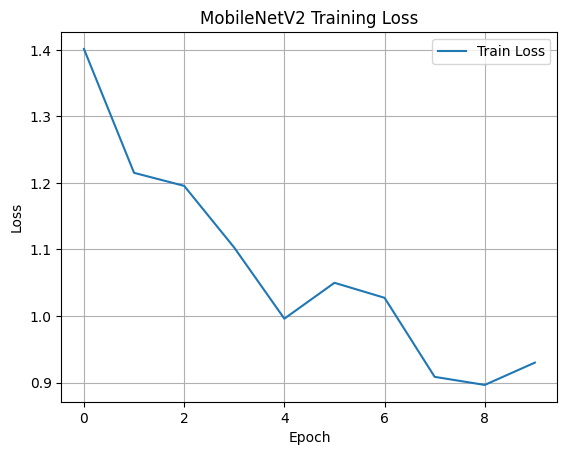

In [17]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.title("MobileNetV2 Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


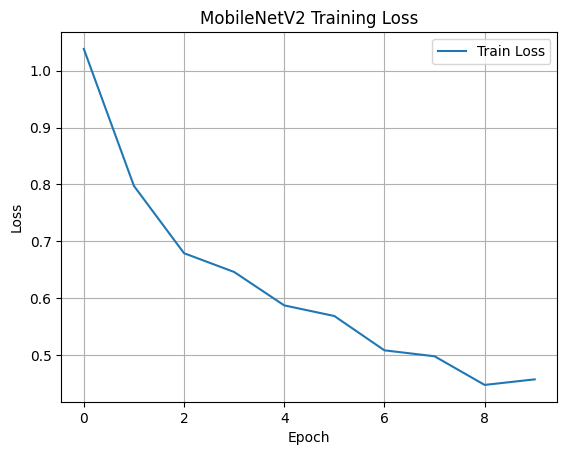

In [64]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.title("MobileNetV2 Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
val_set = ISICDataset(
    csv_path=VAL_LABELS_DIR,
    img_dir=VAL_IMG_DIR,
    transform=val_transform,
    set_state='val'
)

val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=2)


In [19]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(model, val_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"✅ Validation Accuracy: {acc:.4f}")
    print(f"✅ Validation Macro F1: {f1:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=CLASS_NAMES)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Validation Confusion Matrix")
    plt.show()


✅ Validation Accuracy: 0.7565
✅ Validation Macro F1: 0.6231


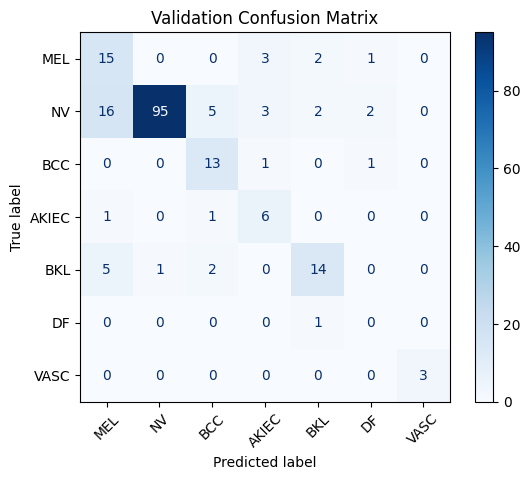

In [63]:
evaluate_model(model, val_loader)